In [1]:
pip install torchviz

In [2]:
!pip install albumentations==0.4.6

In [3]:
import albumentations
import sys, os, random
import cv2 as cv
import torch
import torch.optim as optim
from torchviz import make_dot
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, RGBShift, RandomScale, RandomGamma, NoOp, CLAHE, CenterCrop, GaussianBlur, OneOf, Resize, PadIfNeeded, HorizontalFlip, Normalize, ToGray, ShiftScaleRotate, RandomBrightnessContrast, HueSaturationValue

In [4]:
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [5]:
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [6]:
from Models.CapsuleNet import VggCapsule, CapsuleLoss
from Train.Train import Train
from Dataset.DFDC import DFDC
from Utils.Utils import gridshow, view_capsule_activation
from Eval.Eval import Eval

In [7]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [8]:
data_transforms = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

data_transforms_test = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [9]:
train_image_datasets = DFDC(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDC(TESTING_DATA_FOLDER, data_transforms_test)

In [10]:
writer = SummaryWriter('/content/drive/MyDrive/Colab Notebooks/Tensorboard_Log/Pytorch_CapsuleVGG/'+str(datetime.now()))

In [11]:
device = torch.device("cuda:0")
model = VggCapsule(random=True, dropout=0.05)

for param in model.CapsuleNet.parameters():
    param.requires_grad = True
criterion = CapsuleLoss()
optimizer = optim.Adam(model.CapsuleNet.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model = Train(model, train_image_datasets, device, writer)
model, loader = model.run(criterion = criterion, optimizer = optimizer, scheduler = scheduler)

Epoch 1/10



train Loss: 2.8489 Acc: 0.6878



val Loss: 2.8591 Acc: 0.6780

Epoch 2/10



train Loss: 2.8092 Acc: 0.7456



val Loss: 2.7971 Acc: 0.7488

Epoch 3/10



train Loss: 2.7910 Acc: 0.7918



val Loss: 2.8022 Acc: 0.6829

Epoch 4/10



train Loss: 2.7791 Acc: 0.8131



val Loss: 2.7775 Acc: 0.8049

Epoch 5/10



train Loss: 2.7757 Acc: 0.8265



val Loss: 2.7759 Acc: 0.7878

Epoch 6/10



train Loss: 2.7750 Acc: 0.8278



val Loss: 2.7763 Acc: 0.7878

Epoch 7/10



train Loss: 2.7713 Acc: 0.8387



val Loss: 2.7782 Acc: 0.7902

Epoch 8/10



train Loss: 2.7727 Acc: 0.8363



val Loss: 2.7783 Acc: 0.8098

Epoch 9/10



train Loss: 2.7694 Acc: 0.8411



val Loss: 2.7788 Acc: 0.8024

Epoch 10/10



train Loss: 2.7731 Acc: 0.8381



val Loss: 2.7744 Acc: 0.7854

Training complete in 3m 13s
Best val Acc: 0.809756


In [12]:
eval = Eval(model,test_image_datasets,device)
eval.run()


F1 Score: 0.7472575691092584
Log Loss: 0.6064520648991069
Confusion Matrix:
[[82 13]
 [35 62]]


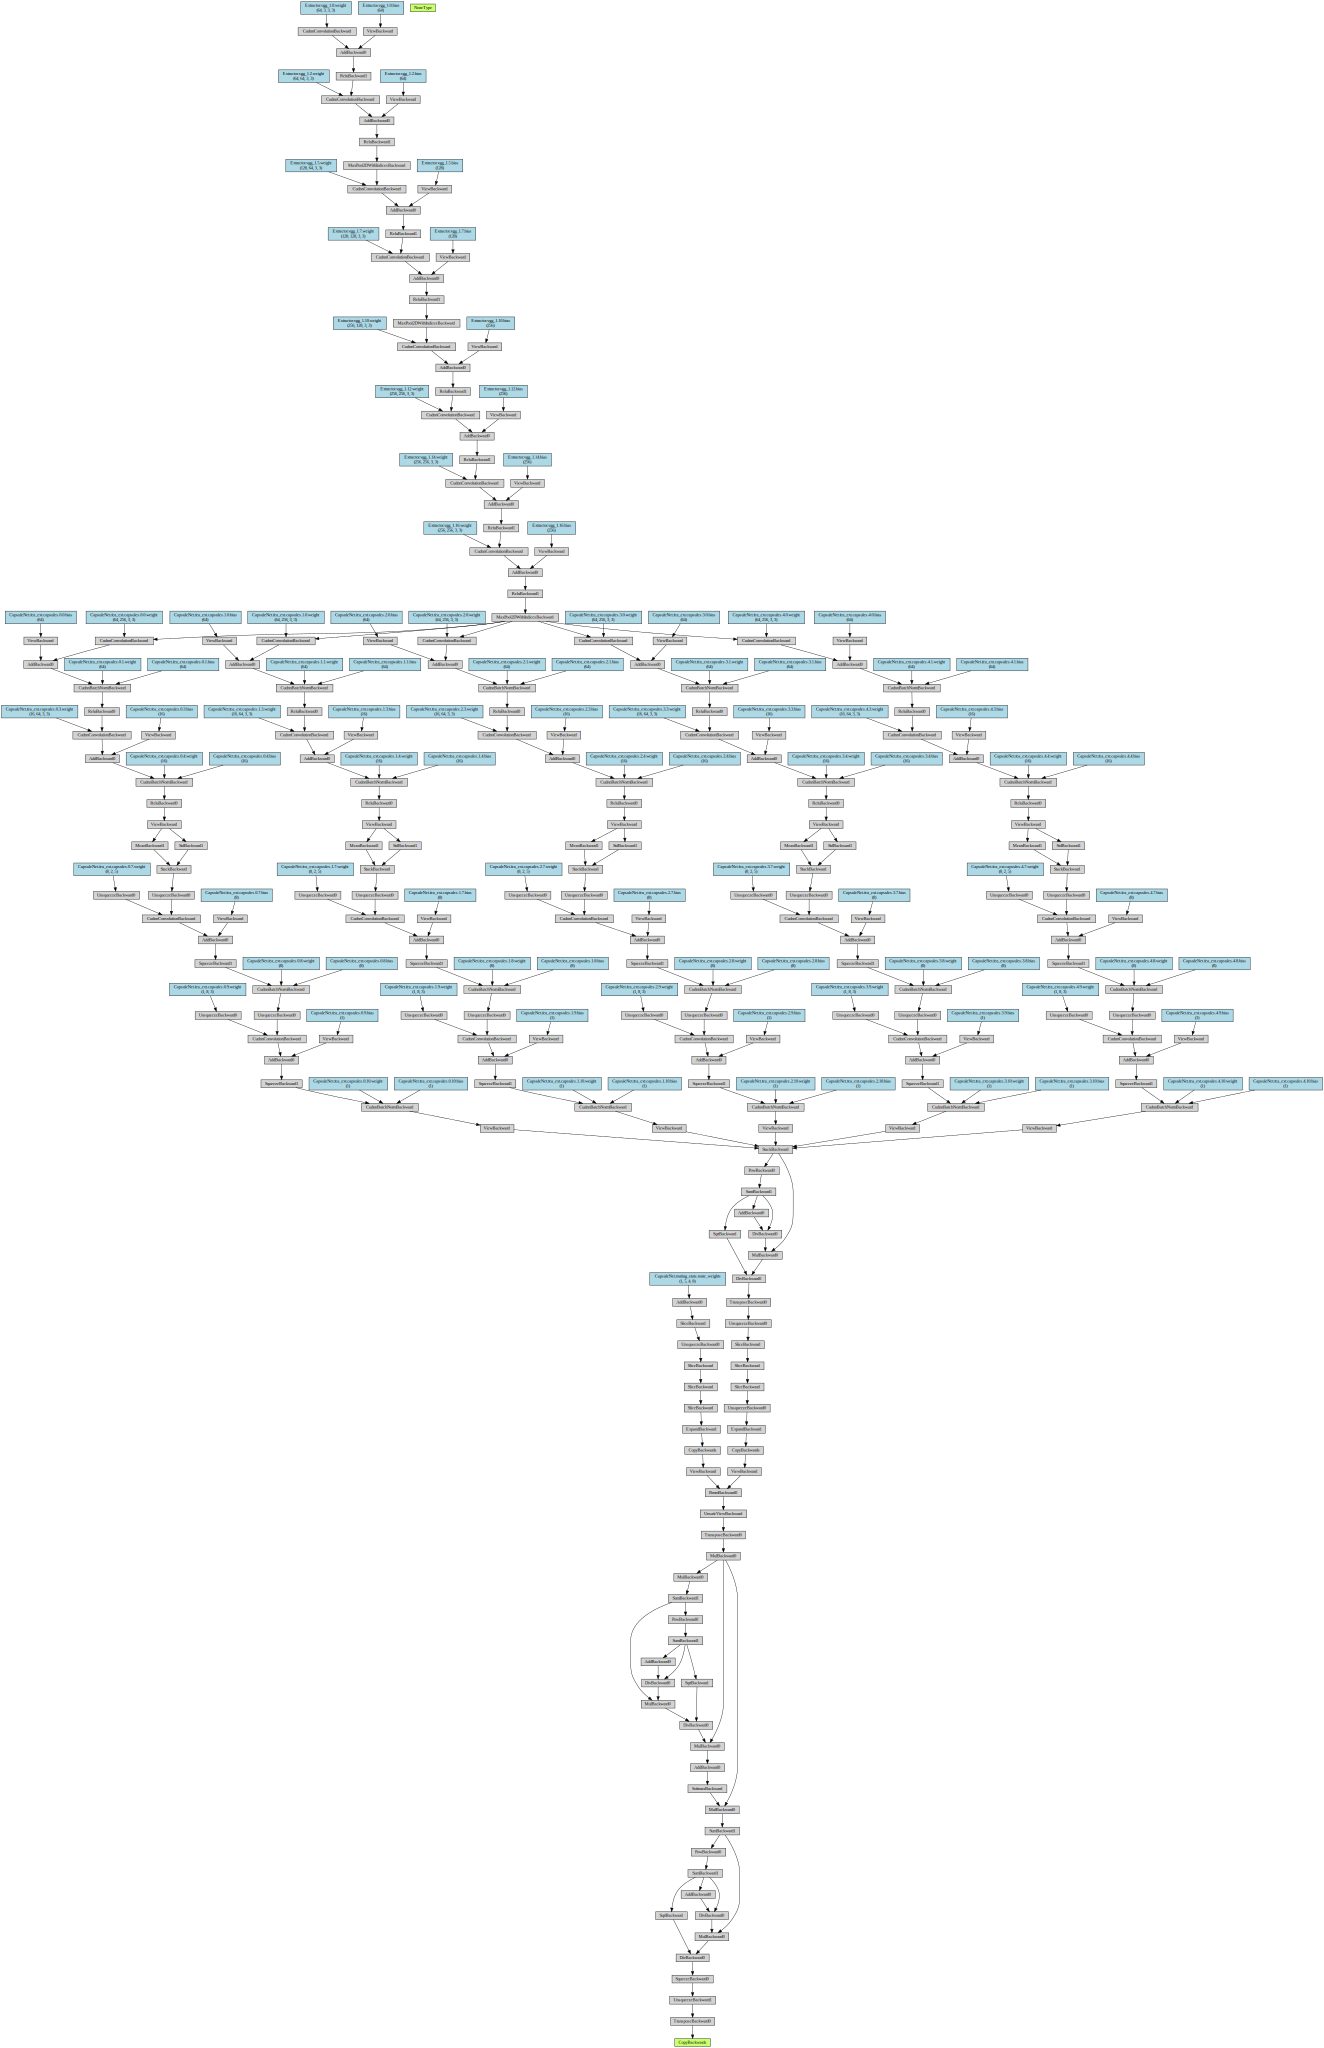

In [13]:
x, label = next(iter(loader['val']))
y = model(x.to(device))
make_dot(y, params=dict(model.named_parameters()))

Capsule: capsule0, prediction: 0.3856939673423767, actual: 0


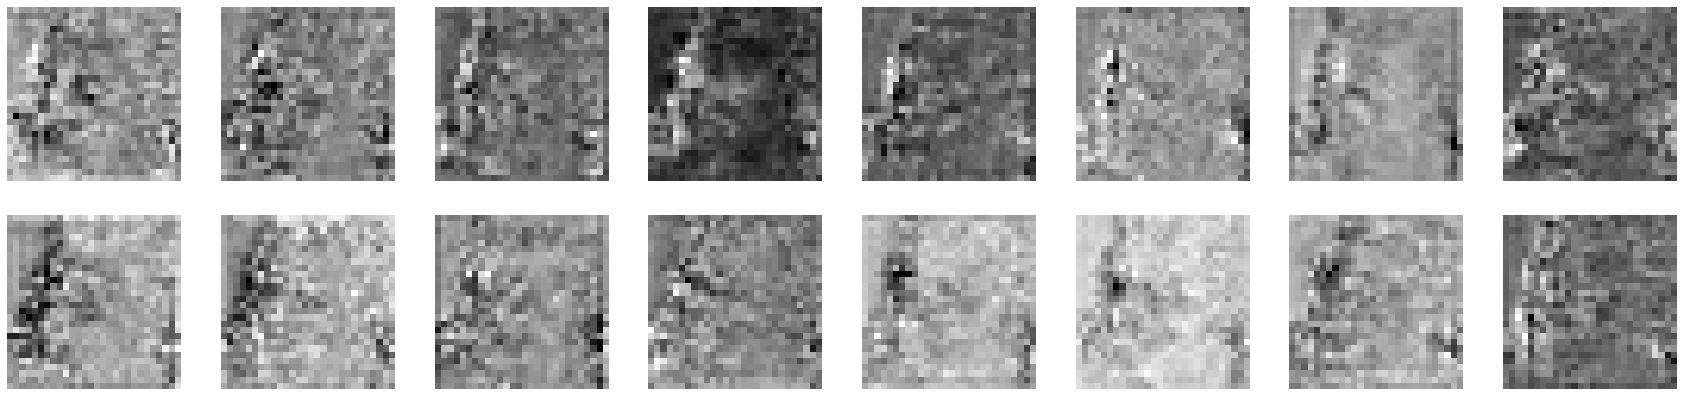

Capsule: capsule1, prediction: 0.3856939673423767, actual: 0


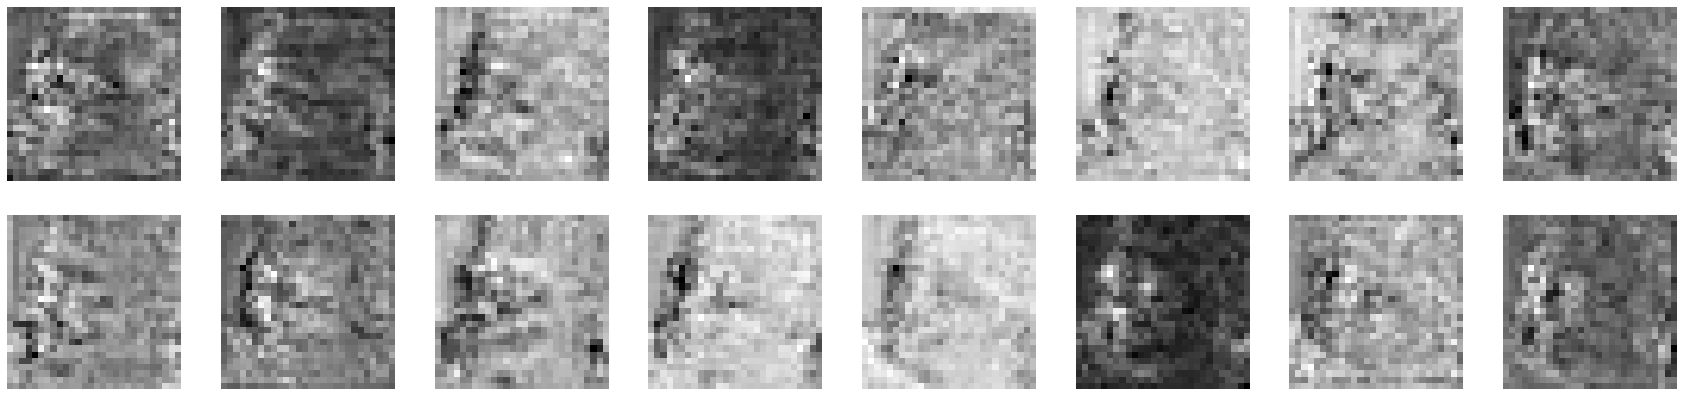

Capsule: capsule2, prediction: 0.3856939673423767, actual: 0


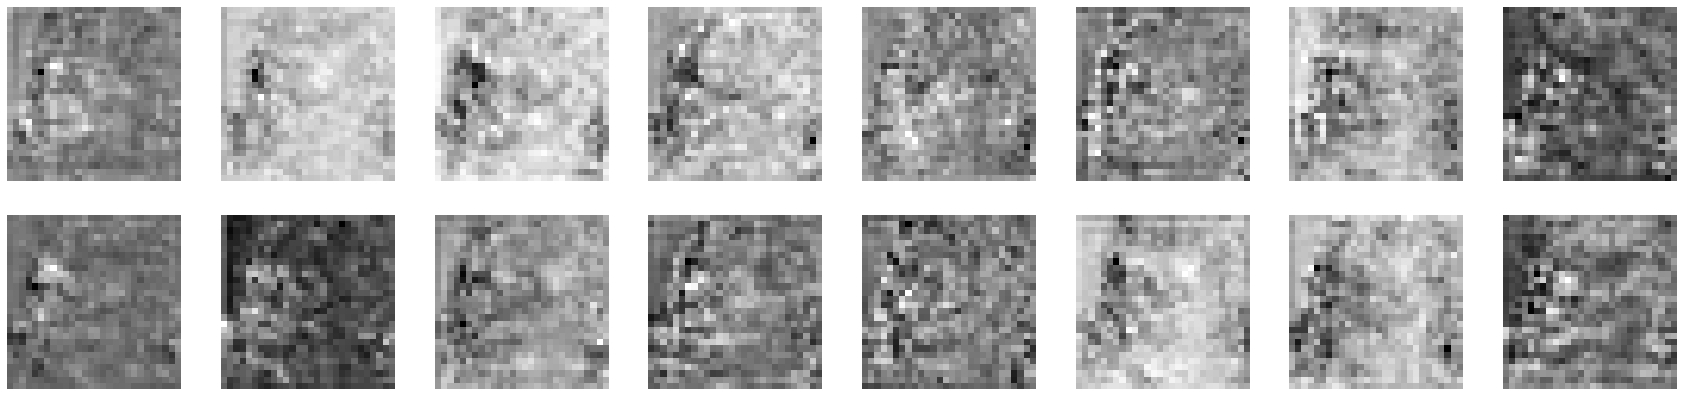

Capsule: capsule3, prediction: 0.3856939673423767, actual: 0


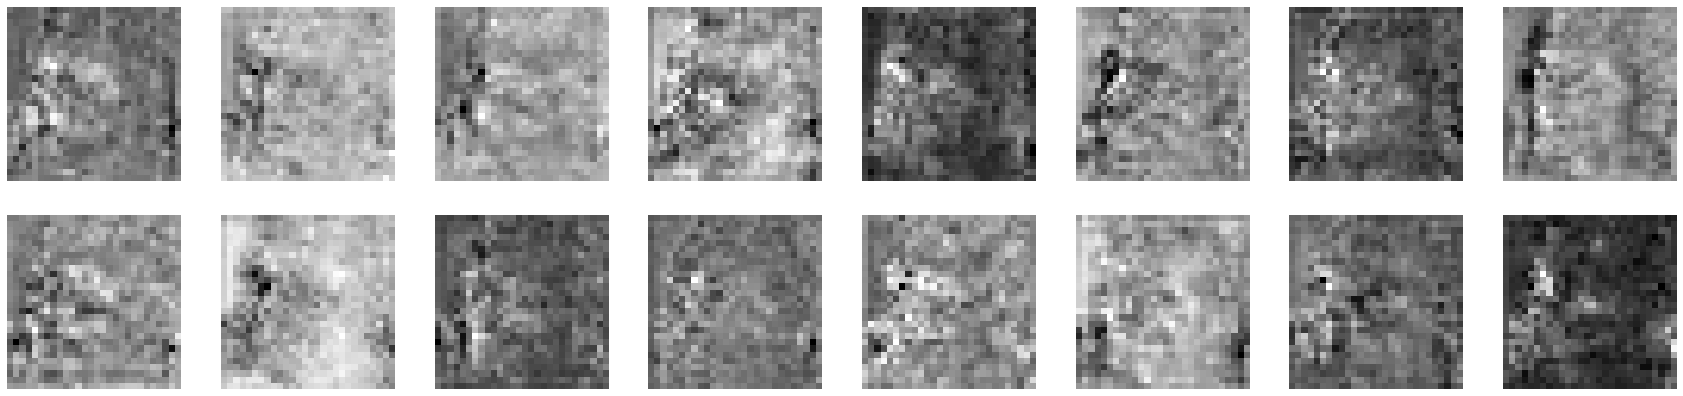

Capsule: capsule4, prediction: 0.3856939673423767, actual: 0


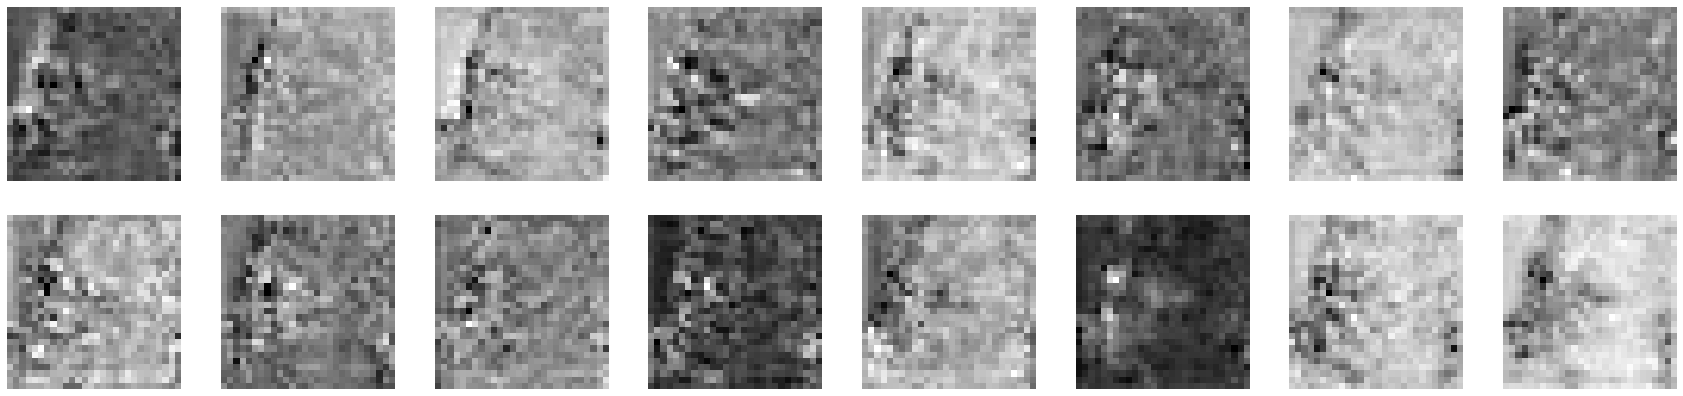

In [14]:
view_capsule_activation(model, device, x, label)

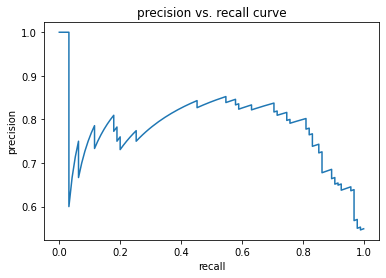

In [15]:
eval.plot_precisionrecall()

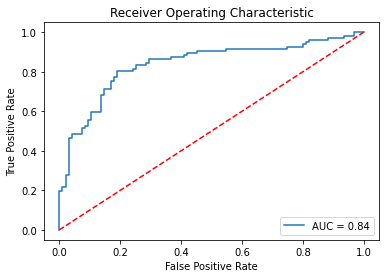

In [16]:
eval.plot_roc()